# SLEAP Distance Calculation

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob

In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [3]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

## Inputs & Data

Explanation of each input and where it comes from.

In [4]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
THORAX_INDEX = 1
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.read_excel("./video_to_frame_and_subject.xlsx")
SLEAP_DIR = "/scratch/back_up/reward_competition_extention/proc/id_corrected"
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
MED_PC_WIDTH = 29.5
MED_PC_HEIGHT = 24
FRAME_RATE = 22

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [5]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names

def calc_bmi(weight, height):
    """
    This is a function that calculates BMI.
    it uses height and weight...etc.
    Meghan plz show us your docsctring format here.
    """
    bmi = weight/(height**2)
    return(bmi)


In [6]:
def get_sleap_tracks_from_h5(filename):
    """
    Retrieve pose tracking data (tracks) from a SLEAP-generated h5 file.
    
    This function is intended for use with Pandas' apply method on columns containing filenames.
    
    Parameters:
    ----------
    filename : str
        Path to the SLEAP h5 file containing pose tracking data.
        
    Returns:
    -------
    np.ndarray
        A transposed version of the 'tracks' dataset in the provided h5 file.
        
    Example:
    --------
    df['tracks'] = df['filename_column'].apply(get_sleap_tracks_from_h5)
    
    """
    with h5py.File(filename, "r") as f:
        return f["tracks"][:].T

In [7]:
def get_sleap_track_names_from_h5(filename):
    """
    Retrieve the names of tracked features from a SLEAP-generated h5 file.
    
    This function is intended for use with Pandas' apply method on columns containing filenames.
    
    Parameters:
    ----------
    filename : str
        Path to the SLEAP h5 file containing pose tracking data.
        
    Returns:
    -------
    h5py.Dataset
        The 'track_names' dataset in the provided h5 file, representing the names of the tracked features.
        
    Example:
    --------
    df['track_names'] = df['filename_column'].apply(get_sleap_track_names_from_h5)
    
    """
    with h5py.File(filename, "r") as f:
        return [item.tobytes().decode('utf-8') for item in f["track_names"][:]]


In [8]:
def get_node_names_from_sleap(filename):
    """
    Retrieve node names from a SLEAP h5 file.

    Parameters:
    - filename (str): Path to the SLEAP h5 file.

    Returns:
    - list of str: List of node names.
    """
    with h5py.File(filename, "r") as f:
        return [n.decode() for n in f["node_names"][:]]

In [9]:

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [10]:
def compute_velocity(node_loc, window_size=25, polynomial_order=3):
    """
    Calculate the velocity of tracked nodes from pose data.
    
    The function utilizes the Savitzky-Golay filter to smooth the data and compute the velocity.
    
    Parameters:
    ----------
    node_loc : numpy.ndarray
        The location of nodes, represented as an array of shape [frames, 2]. 
        Each row represents x and y coordinates for a particular frame.
        
    window_size : int, optional
        The size of the window used for the Savitzky-Golay filter. 
        Represents the number of consecutive data points used when smoothing the data.
        Default is 25.
        
    polynomial_order : int, optional
        The order of the polynomial fit to the data within the Savitzky-Golay filter window.
        Default is 3.

    Returns:
    -------
    numpy.ndarray
        The velocity for each frame, calculated from the smoothed x and y coordinates.
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    # For each coordinate (x and y), smooth the data and calculate the derivative (velocity)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], window_size, polynomial_order, deriv=1)
    
    # Calculate the magnitude of the velocity vectors for each frame
    node_vel = np.linalg.norm(node_loc_vel, axis=1)

    return node_vel

In [11]:
def extract_sleap_data(filename):
    """
    Extracts coordinates, names of body parts, and track names from a SLEAP file.
    
    Parameters:
    - filename (str): Path to the SLEAP file.
    
    Returns:
    - tuple: A tuple containing the following elements:
        * locations (numpy.ndarray): Array containing the coordinates.
        * node_names (list of str): List of body part names.
        * track_names (list of str): List of track names.
    
    Example:
    >>> locations, node_names, track_names = extract_sleap_data("path/to/sleap/file.h5")
    """
    result = {}
    with h5py.File(filename, "r") as f:
        result["locations"] = f["tracks"][:].T
        result["node_names"] = [n.decode() for n in f["node_names"][:]]
        result["track_names"] = [n.decode() for n in f["track_names"][:]]

    return result

In [12]:
def rescale_dimension_in_array(arr, dimension=0, ratio=1):
    """
    Rescale values of a specified dimension in a 3D numpy array for the entire array.
    
    Parameters:
    - arr (numpy.ndarray): A 3D numpy array where the third dimension is being rescaled.
    - dimension (int, default=0): Specifies which dimension (0 or 1) of the third 
                                  dimension in the array should be rescaled. 
                                  For instance, in many contexts:
                                  0 represents the x-coordinate, 
                                  1 represents the y-coordinate.
    - ratio (float, default=1): The scaling factor to be applied.
    
    Returns:
    - numpy.ndarray: The rescaled array.
    """
    
    arr[:,:,dimension] *= ratio
    return arr

# Reading in the h5 files between recordings

In [13]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.dropna(subset="start_frame")

In [14]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj
0,/scratch/back_up/reward_competition_extention/...,32792.0,68495.0,1.4,1.1_1.4
1,/scratch/back_up/reward_competition_extention/...,0.0,32316.0,1.1_1.4,1.1_1.4
2,/scratch/back_up/reward_competition_extention/...,32792.0,68495.0,1.1,1.1_1.4
4,/scratch/back_up/reward_competition_extention/...,32860.0,68288.0,1.2,1.1_1.2
5,/scratch/back_up/reward_competition_extention/...,2027.0,32240.0,1.1_1.2,1.1_1.2


In [15]:
# We will be indexing for the frames, so they must be integers and not floats
VIDEO_TO_FRAME_AND_SUBJECT_DF["start_frame"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["start_frame"].astype(int)
VIDEO_TO_FRAME_AND_SUBJECT_DF["stop_frame"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["stop_frame"].astype(int)

In [16]:
# Getting the basename of the file which corresponds to the ephys recording that the h5 file came from
VIDEO_TO_FRAME_AND_SUBJECT_DF["recording_name"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: os.path.basename(x).split(".")[0])

In [17]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: extract_sleap_data(x))


In [18]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["locations"])

In [19]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["all_sleap_data"].apply(lambda x: x["track_names"])

In [20]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

0                                                [1.4]
1    [1.1, 1.4, track_867, track_868, track_869, tr...
2                                                [1.1]
4                                                [1.2]
5    [1.1, 1.2, track_16, track_18, track_40, track...
6                                                [1.1]
Name: track_names, dtype: object

In [21]:
# Getting the coordinates of all the body parts for all the animals for the entire recording
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: get_sleap_tracks_from_h5(x))
# Getting the name of the tracks which correspond to the animal id
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: get_sleap_track_names_from_h5(x))

In [22]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"].iloc[0].shape

(68495, 6, 2, 1)

In [23]:
# Making sure all the subject IDs are strings instead of floating point numbers
VIDEO_TO_FRAME_AND_SUBJECT_DF["individual_subj"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["individual_subj"].astype(str)

In [24]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["track_names"]

0                                                [1.4]
1    [1.1, 1.4, track_867, track_868, track_869, tr...
2                                                [1.1]
4                                                [1.2]
5    [1.1, 1.2, track_16, track_18, track_40, track...
6                                                [1.1]
Name: track_names, dtype: object

In [25]:
# Getting the indexes of each subject from the track list
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["track_names"].index(k) for k in x["individual_subj"].split("_")}, axis=1)

In [26]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_index"]

0              {'1.4': 0}
1    {'1.1': 0, '1.4': 1}
2              {'1.1': 0}
4              {'1.2': 0}
5    {'1.1': 0, '1.2': 1}
6              {'1.1': 0}
Name: subject_to_index, dtype: object

In [27]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k:v for k, v in x["subject_to_index"].items()}, axis=1)

In [28]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"]

0              {'1.4': 0}
1    {'1.1': 0, '1.4': 1}
2              {'1.1': 0}
4              {'1.2': 0}
5    {'1.1': 0, '1.2': 1}
6              {'1.1': 0}
Name: subject_to_tracks, dtype: object

In [29]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: x["locations"][:,:,:,v] for k, v in x["subject_to_index"].items()}, axis=1)

In [30]:
# Convert dictionary items to list of items
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"].apply(lambda x: list(x.items()))

In [31]:
# Explode based on the lists
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.explode(["subject_to_tracks"]).reset_index(drop=True)

In [32]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj,recording_name,all_sleap_data,locations,track_names,subject_to_index,subject_to_tracks
0,/scratch/back_up/reward_competition_extention/...,32792,68495,1.4,1.1_1.4,20230618_100636_standard_comp_to_omission_D2_s...,{'locations': [[[[340.27038574] [388.14276123...,"[[[[340.27038574], [388.14276123]], [[324.3432...",[1.4],{'1.4': 0},"(1.4, [[[340.27038574 388.14276123], [324.3432..."
1,/scratch/back_up/reward_competition_extention/...,0,32316,1.1_1.4,1.1_1.4,20230618_100636_standard_comp_to_omission_D2_s...,{'locations': [[[[340.27038574 227.90209961 ...,[[[[340.27038574 227.90209961 nan ...,"[1.1, 1.4, track_867, track_868, track_869, tr...","{'1.1': 0, '1.4': 1}","(1.1, [[[340.27038574 388.14276123], [324.3432..."
2,/scratch/back_up/reward_competition_extention/...,0,32316,1.1_1.4,1.1_1.4,20230618_100636_standard_comp_to_omission_D2_s...,{'locations': [[[[340.27038574 227.90209961 ...,[[[[340.27038574 227.90209961 nan ...,"[1.1, 1.4, track_867, track_868, track_869, tr...","{'1.1': 0, '1.4': 1}","(1.4, [[[227.90209961 336.52835083], [243.5521..."
3,/scratch/back_up/reward_competition_extention/...,32792,68495,1.1,1.1_1.4,20230618_100636_standard_comp_to_omission_D2_s...,"{'locations': [[[[nan] [nan]], [[nan] [nan]]...","[[[[nan], [nan]], [[nan], [nan]], [[nan], [nan...",[1.1],{'1.1': 0},"(1.1, [[[nan nan], [nan nan], [nan nan], [nan ..."
4,/scratch/back_up/reward_competition_extention/...,32860,68288,1.2,1.1_1.2,20230620_114347_standard_comp_to_omission_D4_s...,{'locations': [[[[303.96658325] [368.13119507...,"[[[[303.96658325], [368.13119507]], [[299.8300...",[1.2],{'1.2': 0},"(1.2, [[[303.96658325 368.13119507], [299.8300..."


In [33]:
# Split tuple of (key, value) into separate columns
VIDEO_TO_FRAME_AND_SUBJECT_DF[['subject_id', 'subject_locations']] = pd.DataFrame(VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_to_tracks"].tolist(), index=VIDEO_TO_FRAME_AND_SUBJECT_DF.index)

In [34]:
VIDEO_TO_FRAME_AND_SUBJECT_DF = VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(columns=["subject_to_tracks"])

In [35]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_id"]

0    1.4
1    1.1
2    1.4
3    1.1
4    1.2
5    1.1
6    1.2
7    1.1
Name: subject_id, dtype: object

In [36]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_locations"].apply(lambda x: fill_missing(x))

## Getting the coordinates of the corners

In [37]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.fixed.1_subj.round_1.id_corrected.h5'

In [38]:
# Each corner file is the in the same folder and has the same basename of the pose tracking file 
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].apply(lambda x: "{}.fixed.corner.h5".format(x.split("fixed")[0].strip(".")))

In [39]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].iloc[0]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.fixed.corner.h5'

In [40]:
# Getting the indexes of each corner location
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: get_node_names_from_sleap(x))

In [41]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"]

0    [box_top_left, box_bottom_right, box_bottom_le...
1    [box_top_left, box_bottom_right, box_bottom_le...
2    [box_top_left, box_bottom_right, box_bottom_le...
3    [box_top_left, box_bottom_right, box_bottom_le...
4    [reward_port, box_top_left, box_bottom_right, ...
5    [reward_port, box_top_left, box_bottom_right, ...
6    [reward_port, box_top_left, box_bottom_right, ...
7    [reward_port, box_top_left, box_bottom_right, ...
Name: corner_parts, dtype: object

In [42]:
# Getting the coordinates of all the corners
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_path"].apply(lambda x: get_sleap_tracks_from_h5(x))

In [43]:
# Parsing out each corner and creating a dictionary of name to coordinates
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {part: x["corner_to_coordinate"][:,index,:,:] for index, part in enumerate(x["corner_parts"])}, axis=1)

In [44]:
# Filtering out all the Nans because there's only one labeled frame
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: {k: v[~np.isnan(v)] for k, v in x["corner_to_coordinate"].items()}, axis=1)

In [45]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0    {'box_top_left': [210.30936448661504, 125.0467...
1    {'box_top_left': [210.30936448661504, 125.0467...
2    {'box_top_left': [210.30936448661504, 125.0467...
3    {'box_top_left': [236.38150141547158, 131.2095...
4    {'reward_port': [324.08885973592385, 405.86618...
5    {'reward_port': [324.08885973592385, 405.86618...
6    {'reward_port': [324.08885973592385, 405.86618...
7    {'reward_port': [340.03875718352816, 408.11416...
Name: corner_to_coordinate, dtype: object

In [46]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].iloc[5]

{'reward_port': array([324.08885974, 405.86618442]),
 'box_top_left': array([209.01820611, 120.42661182]),
 'box_bottom_right': array([433.18591187, 381.64613662]),
 'box_bottom_left': array([218.94806421, 388.54962778]),
 'box_top_right': array([424.07586736, 116.63573947])}

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [47]:
# Using the x-coordinates for the width
VIDEO_TO_FRAME_AND_SUBJECT_DF["bottom_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][0] - x["box_bottom_left"][0])
VIDEO_TO_FRAME_AND_SUBJECT_DF["top_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_top_right"][0] - x["box_top_left"][0])


In [48]:
# Using the y-coordinates for the height
VIDEO_TO_FRAME_AND_SUBJECT_DF["right_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_right"][1] - x["box_top_right"][1])
VIDEO_TO_FRAME_AND_SUBJECT_DF["left_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"].apply(lambda x: x["box_bottom_left"][1] - x["box_top_left"][1])


In [49]:
# averaging the width and height by adding both sides and then getting the mean
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [50]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"] = MED_PC_WIDTH / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_width"]
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"] = MED_PC_HEIGHT / VIDEO_TO_FRAME_AND_SUBJECT_DF["average_height"]

In [51]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["height_ratio"]

0    0.092440
1    0.092440
2    0.092440
3    0.093061
4    0.090034
5    0.090034
6    0.090034
7    0.092571
Name: height_ratio, dtype: float64

In [52]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["width_ratio"]

0    0.137652
1    0.137652
2    0.137652
3    0.140174
4    0.137434
5    0.137434
6    0.137434
7    0.140108
Name: width_ratio, dtype: float64

## Converting Pixels to cm

In [53]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_locations"][0].shape

(68495, 6, 2)

- Converting the X-dimension

In [54]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: rescale_dimension_in_array(x["subject_locations"], dimension=0, ratio=x["width_ratio"]), axis=1)

- Converting the Y-dimension

In [55]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: rescale_dimension_in_array(x["rescaled_locations"], dimension=1, ratio=x["height_ratio"]), axis=1)

In [56]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"]

0    {'box_top_left': [210.30936448661504, 125.0467...
1    {'box_top_left': [210.30936448661504, 125.0467...
2    {'box_top_left': [210.30936448661504, 125.0467...
3    {'box_top_left': [236.38150141547158, 131.2095...
4    {'reward_port': [324.08885973592385, 405.86618...
5    {'reward_port': [324.08885973592385, 405.86618...
6    {'reward_port': [324.08885973592385, 405.86618...
7    {'reward_port': [340.03875718352816, 408.11416...
Name: corner_to_coordinate, dtype: object

In [57]:
# Normalize dictionary column
normalized = pd.json_normalize(VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_to_coordinate"])

# Drop the original column and concat the normalized DataFrame
VIDEO_TO_FRAME_AND_SUBJECT_DF = pd.concat([VIDEO_TO_FRAME_AND_SUBJECT_DF.drop(["corner_to_coordinate"], axis=1), normalized], axis=1)


In [58]:
for corner in VIDEO_TO_FRAME_AND_SUBJECT_DF["corner_parts"].iloc[0]:
    VIDEO_TO_FRAME_AND_SUBJECT_DF[corner] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [x[corner][0]*x["width_ratio"], x[corner][1]*x["height_ratio"]], axis=1)

In [59]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["box_bottom_left"] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda x: [x["box_bottom_left"][0]*x["width_ratio"], x["box_bottom_left"][1]*x["height_ratio"]], axis=1)

## Looking over the tracks

In [60]:
FILE_INDEX = 2

In [61]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[FILE_INDEX]

'/scratch/back_up/reward_competition_extention/proc/id_corrected/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.fixed.2_subj.round_1.id_corrected.h5'

In [62]:
with h5py.File(VIDEO_TO_FRAME_AND_SUBJECT_DF["file_path"].iloc[FILE_INDEX], "r") as f:
    dset_names = list(f.keys())
    locations = VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].iloc[FILE_INDEX]
    node_names = [n.decode() for n in f["node_names"][:]]
    
print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(68495, 6, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [63]:
thorax_loc = locations[:, THORAX_INDEX, :]

Text(0, 0.5, 'Coordinate Position')

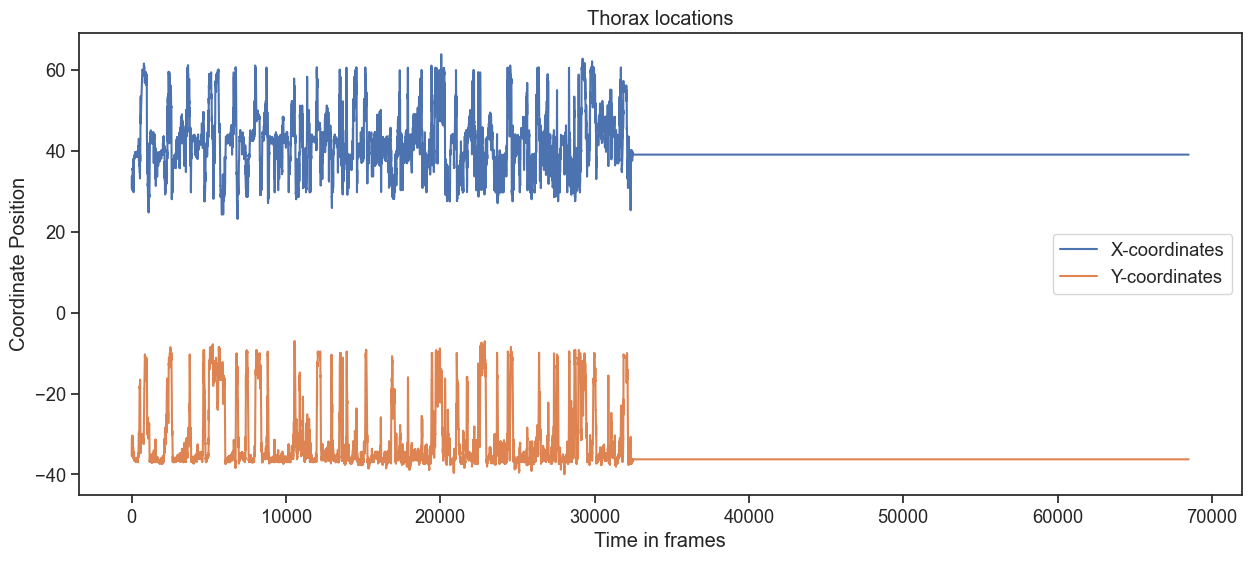

In [64]:
fig, ax = plt.subplots()

plt.plot(thorax_loc[:,0],label='X-coordinates')
# Converting to negative so that we can see both x and y track
plt.plot(-1*thorax_loc[:,1], label='Y-coordinates')

plt.legend(loc="center right")
plt.title('Thorax locations')
plt.xlabel("Time in frames")
plt.ylabel("Coordinate Position")

Text(0, 0.5, 'Y-Coordinates')

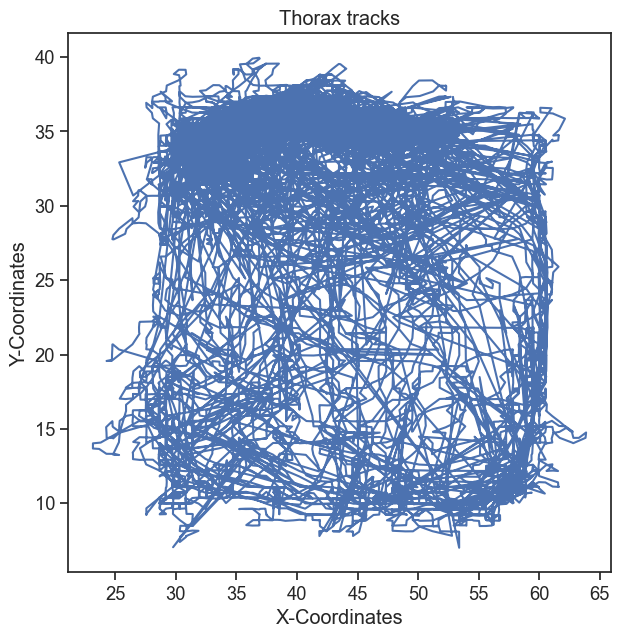

In [65]:
plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0],thorax_loc[:,1])


plt.title('Thorax tracks')
plt.xlabel("X-Coordinates")
plt.ylabel("Y-Coordinates")


In [66]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].iloc[0].shape

(68495, 6, 2)

## Calculate Velocity

In [67]:
WINDOW_SIZE = 25

In [68]:
FRAME_START = 0

In [69]:
FRAME_STOP = 1000

In [70]:
file_index = 1

In [71]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_locations"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["rescaled_locations"].apply(lambda x: x[:,THORAX_INDEX,:])

In [72]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_velocities"] = VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_locations"].apply(lambda x: compute_velocity(x, window_size=WINDOW_SIZE))

Text(0.5, 1.0, 'Thorax locations')

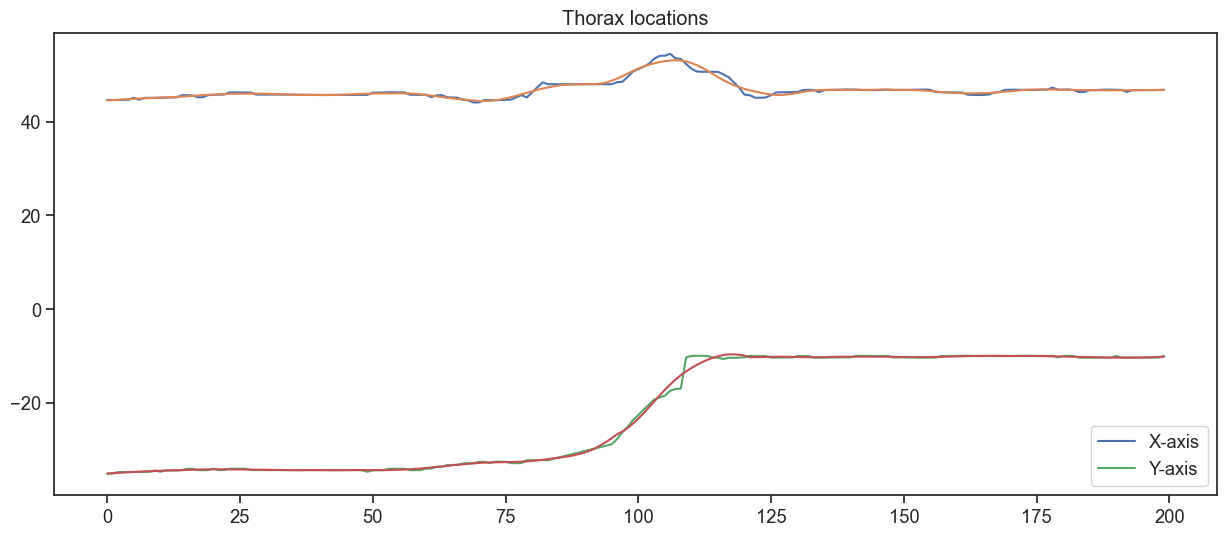

In [73]:
plt.figure()
plt.plot(VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_locations"].iloc[file_index][FRAME_START:200,0], label="X-axis")
plt.plot(savgol_filter(VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_locations"].iloc[file_index][FRAME_START:200,0], 25, 3, deriv=0))

plt.plot(-1*VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_locations"].iloc[file_index][FRAME_START:200,1], label="Y-axis")
plt.plot(-1*savgol_filter(VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_locations"].iloc[file_index][FRAME_START:200,1], 25, 3, deriv=0))

plt.legend()
plt.title('Thorax locations')



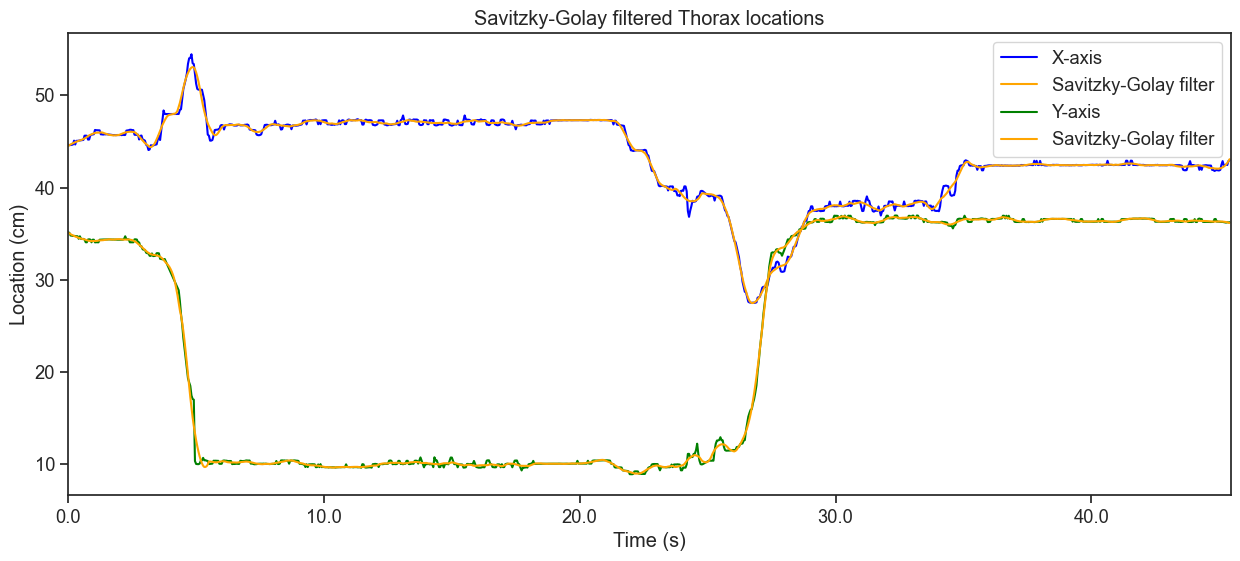

In [74]:
fig, ax = plt.subplots()

plt.title('Savitzky-Golay filtered Thorax locations')
plt.xlabel("Time (s)")
plt.ylabel("Location (cm)")

sns.lineplot(VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_locations"].iloc[file_index][FRAME_START:FRAME_STOP,0], label="X-axis", color="blue")
sns.lineplot(savgol_filter(VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_locations"].iloc[file_index][FRAME_START:FRAME_STOP,0], 25, 3, deriv=0), color="orange", label="Savitzky-Golay filter")


sns.lineplot(VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_locations"].iloc[file_index][FRAME_START:FRAME_STOP,1], label="Y-axis", color="green")
sns.lineplot(savgol_filter(VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_locations"].iloc[file_index][FRAME_START:FRAME_STOP,1], 25, 3, deriv=0), color="orange", label="Savitzky-Golay filter")

# Only plotting where the data is
plt.xlim(FRAME_START, FRAME_STOP)
# Making new ticks that are divisible by 10
x_ticks_range = np.arange(FRAME_START, FRAME_STOP, FRAME_RATE*10)
plt.xticks(x_ticks_range)
# Converting the x ticks into seconds
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [str(float(label) // FRAME_RATE) for label in labels]
ax.set_xticklabels(new_labels)

plt.legend()


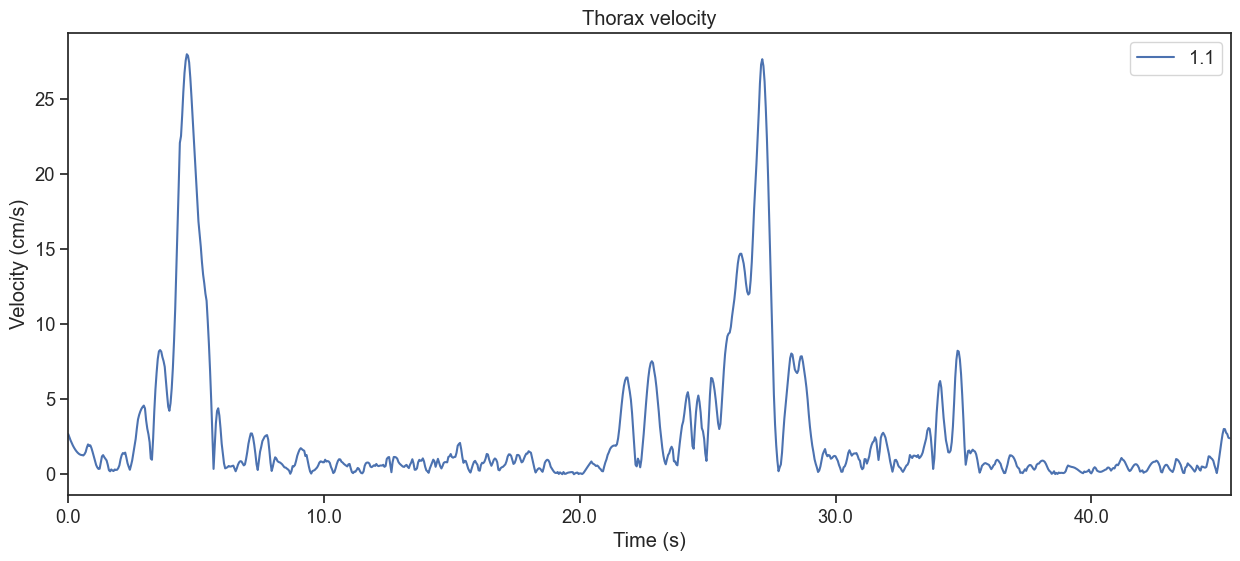

In [75]:
fig, ax = plt.subplots()

plt.title('Thorax velocity')
plt.xlabel("Time (s)")
plt.ylabel("Velocity (cm/s)")

sns.lineplot(VIDEO_TO_FRAME_AND_SUBJECT_DF["thorax_velocities"].iloc[file_index][FRAME_START:FRAME_STOP]*FRAME_RATE, label=VIDEO_TO_FRAME_AND_SUBJECT_DF["subject_id"].iloc[file_index])

# Only plotting where the data is
plt.xlim(FRAME_START, FRAME_STOP)
# Making new ticks that are divisible by 10
x_ticks_range = np.arange(FRAME_START, FRAME_STOP, FRAME_RATE*10)
plt.xticks(x_ticks_range)
# Converting the x ticks into seconds
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [str(float(label) // FRAME_RATE) for label in labels]
ax.set_xticklabels(new_labels)

plt.legend()





# Filtering out all the unnecessary pose estimation

In [100]:
def slice_and_zero(arr, frame_start, frame_end):
    # Create an array of zeros with the same shape as the input array
    result = np.zeros_like(arr)
    
    # Update the zeros array with the values from the input array slice
    result[frame_start:frame_end] = arr[frame_start:frame_end]
    
    return result

In [101]:

# For this example, let's assume we want the slice [:, 1:3], 
# i.e., the last two columns of every row
VIDEO_TO_FRAME_AND_SUBJECT_DF['sliced_locations'] = VIDEO_TO_FRAME_AND_SUBJECT_DF.apply(lambda row: slice_and_zero(row["rescaled_locations"], row["start_frame"], row["stop_frame"]), axis=1)



In [103]:
VIDEO_TO_FRAME_AND_SUBJECT_DF['sliced_locations'].iloc[0]

array([[[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       ...,

       [[41.34262963, 34.79000306],
        [40.77135283, 36.2008643 ],
        [43.98933431, 36.26498923],
        [33.61698176, 33.65944259],
        [36.90462319, 35.47941021],
        [42.9404168 , 35.86464499]],

       [[40.7706681 , 34.43453019],
        [41.27402197, 35.8790774 ],
        [43.46409   , 35.52141258],
       

# Combining different parts of recordings

# TODO Get the time stamps

In [76]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.columns

Index(['file_path', 'start_frame', 'stop_frame', 'individual_subj', 'all_subj',
       'recording_name', 'all_sleap_data', 'locations', 'track_names',
       'subject_to_index', 'subject_id', 'subject_locations', 'corner_path',
       'corner_parts', 'bottom_width', 'top_width', 'right_height',
       'left_height', 'average_height', 'average_width', 'width_ratio',
       'height_ratio', 'rescaled_locations', 'box_top_left',
       'box_bottom_right', 'box_bottom_left', 'box_top_right', 'reward_port',
       'thorax_locations', 'thorax_velocities'],
      dtype='object')

In [77]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.head()

,file_path,start_frame,stop_frame,individual_subj,all_subj,recording_name,all_sleap_data,locations,track_names,subject_to_index,...,width_ratio,height_ratio,rescaled_locations,box_top_left,box_bottom_right,box_bottom_left,box_top_right,reward_port,thorax_locations,thorax_velocities
0,/scratch/back_up/reward_competition_extention/...,32792,68495,1.4,1.1_1.4,20230618_100636_standard_comp_to_omission_D2_s...,{'locations': [[[[340.27038574] [388.14276123...,"[[[[340.27038574], [388.14276123]], [[324.3432...",[1.4],{'1.4': 0},...,0.137652,0.092440,"[[[46.838967596646405, 35.8797798363605], [44....","[28.94954695212123, 11.559275766924861]","[59.48640645086775, 35.36893406869099]","[4.101212909553137, 3.26085168183482]","[58.25716394690266, 11.0851249161892]","[44.59493426883317, 37.290222508536225]","[[44.646568117031, 35.14186500770354], [44.604...","[0.12193470245670596, 0.11194330182220531, 0.1..."
1,/scratch/back_up/reward_competition_extention/...,0,32316,1.1_1.4,1.1_1.4,20230618_100636_standard_comp_to_omission_D2_s...,{'locations': [[[[340.27038574 227.90209961 ...,[[[[340.27038574 227.90209961 nan ...,"[1.1, 1.4, track_867, track_868, track_869, tr...","{'1.1': 0, '1.4': 1}",...,0.137652,0.092440,"[[[46.838967596646405, 35.8797798363605], [44....","[28.94954695212123, 11.559275766924861]","[59.48640645086775, 35.36893406869099]","[4.101212909553137, 3.26085168183482]","[58.25716394690266, 11.0851249161892]","[44.59493426883317, 37.290222508536225]","[[44.646568117031, 35.14186500770354], [44.604...","[0.12193470245670596, 0.11194330182220531, 0.1..."
2,/scratch/back_up/reward_competition_extention/...,0,32316,1.1_1.4,1.1_1.4,20230618_100636_standard_comp_to_omission_D2_s...,{'locations': [[[[340.27038574 227.90209961 ...,[[[[340.27038574 227.90209961 nan ...,"[1.1, 1.4, track_867, track_868, track_869, tr...","{'1.1': 0, '1.4': 1}",...,0.137652,0.092440,"[[[31.37122566669405, 31.1085619584881], [33.5...","[28.94954695212123, 11.559275766924861]","[59.48640645086775, 35.36893406869099]","[4.101212909553137, 3.26085168183482]","[58.25716394690266, 11.0851249161892]","[44.59493426883317, 37.290222508536225]","[[33.52548807634824, 31.078557439275343], [33....","[0.03986858722504035, 0.011202798172857157, 0...."
3,/scratch/back_up/reward_competition_extention/...,32792,68495,1.1,1.1_1.4,20230618_100636_standard_comp_to_omission_D2_s...,"{'locations': [[[[nan] [nan]], [[nan] [nan]]...","[[[[nan], [nan]], [[nan], [nan]], [[nan], [nan...",[1.1],{'1.1': 0},...,0.140174,0.093061,"[[[30.16917980878218, 35.74821488617344], [27....","[33.13448993399251, 12.210464782039047]","[62.20487870752268, 36.45236548667897]","[4.623240489943855, 3.363999805710559]","[62.911815889791995, 12.39031517500344]","[47.762130656568786, 38.156549438224864]","[[27.601274165874116, 35.77890097551446], [27....","[4.766735774375239e-15, 3.97050377270652e-15, ..."
4,/scratch/back_up/reward_competition_extention/...,32860,68288,1.2,1.1_1.2,20230620_114347_standard_comp_to_omission_D4_s...,{'locations': [[[[303.96658325] [368.13119507...,"[[[[303.96658325], [368.13119507]], [[299.8300...",[1.2],{'1.2': 0},...,0.137434,0.090034,"[[[41.77548574260138, 33.14423168550605], [41....","[28.726306016601946, 10.842459364362139]","[59.534675462363765, 34.36103254330584]","[4.135542067093765, 3.1496128098840956]","[58.282641339237685, 10.501152914297204]","[44.54098011165848, 36.54165425213083]","[[41.20698316579463, 34.980331630480784], [41....","[0.536341827837233, 0.4451994604013153, 0.3615..."


In [78]:
VIDEO_TO_FRAME_AND_SUBJECT_DF.groupby(["subject_id", "recording_name"]).count()

file_path  \
subject_id recording_name                                                  
1.1        20230618_100636_standard_comp_to_omission_D2_su...          2   
           20230620_114347_standard_comp_to_omission_D4_su...          2   
1.2        20230620_114347_standard_comp_to_omission_D4_su...          2   
1.4        20230618_100636_standard_comp_to_omission_D2_su...          2   

                                                               start_frame  \
subject_id recording_name                                                    
1.1        20230618_100636_standard_comp_to_omission_D2_su...            2   
           20230620_114347_standard_comp_to_omission_D4_su...            2   
1.2        20230620_114347_standard_comp_to_omission_D4_su...            2   
1.4        20230618_100636_standard_comp_to_omission_D2_su...            2   

                                                               stop_frame  \
subject_id recording_name                                                   
1.1        20230618_100636_standard_comp_to_omission_D2_su...           2   
           20230620_114347_standard_comp_to_omission_D4_su...           2   
1.2        20230620_114347_standard_comp_to_omission_D4_su...           2   
1.4        20230618_100636_standard_comp_to_omission_D2_su...           2   

                                                               individual_subj  \
subject_id recording_name                                                        
1.1        20230618_100636_standard_comp_to_omission_D2_su...                2   
           20230620_114347_standard_comp_to_omission_D4_su...                2   
1.2        20230620_114347_standard_comp_to_omission_D4_su...                2   
1.4        20230618_100636_standard_comp_to_omission_D2_su...                2   

                                                               all_subj  \
subject_id recording_name                                                 
1.1        20230618_100636_standard_comp_to_omission_D2_su...         2   
           20230620_114347_standard_comp_to_omission_D4_su...         2   
1.2        20230620_114347_standard_comp_to_omission_D4_su...         2   
1.4        20230618_100636_standard_comp_to_omission_D2_su...         2   

                                                               all_sleap_data  \
subject_id recording_name                                                       
1.1        20230618_100636_standard_comp_to_omission_D2_su...               2   
           20230620_114347_standard_comp_to_omission_D4_su...               2   
1.2        20230620_114347_standard_comp_to_omission_D4_su...               2   
1.4        20230618_100636_standard_comp_to_omission_D2_su...               2   

                                                               locations  \
subject_id recording_name                                                  
1.1        20230618_100636_standard_comp_to_omission_D2_su...          2   
           20230620_114347_standard_comp_to_omission_D4_su...          2   
1.2        20230620_114347_standard_comp_to_omission_D4_su...          2   
1.4        20230618_100636_standard_comp_to_omission_D2_su...          2   

                                                               track_names  \
subject_id recording_name                                                    
1.1        20230618_100636_standard_comp_to_omission_D2_su...            2   
           20230620_114347_standard_comp_to_omission_D4_su...            2   
1.2        20230620_114347_standard_comp_to_omission_D4_su...            2   
1.4        20230618_100636_standard_comp_to_omission_D2_su...            2   

                                                               subject_to_index  \
subject_id recording_name                                                         
1.1        20230618_100636_standard_comp_to_omission_D2_su...                 2   
           20230620_114347_standard_comp_to_omission_D4_su...       

In [87]:
VIDEO_TO_FRAME_AND_SUBJECT_DF["locations"]

0    [[[[340.27038574], [388.14276123]], [[324.3432...
1    [[[[340.27038574 227.90209961          nan    ...
2    [[[[340.27038574 227.90209961          nan    ...
3    [[[[nan], [nan]], [[nan], [nan]], [[nan], [nan...
4    [[[[303.96658325], [368.13119507]], [[299.8300...
5    [[[[303.96658325          nan          nan    ...
6    [[[[303.96658325          nan          nan    ...
7    [[[[nan], [nan]], [[nan], [nan]], [[nan], [nan...
Name: locations, dtype: object

In [83]:
def process_group(group):
    max_length = group['thorax_locations']
    
    # Initialize an array of zeros
    combined_arr = np.zeros(max_length)

    for _, row in group.iterrows():
        combined_arr[row["start_frame"]:row["stop_frame"]] = row['thorax_locations'][row["start_frame"]:row["stop_frame"]]
        
    return combined_arr

In [85]:
def process_group(group):
    max_rows = group['thorax_locations'].apply(lambda x: x.shape[0]).max()
    max_cols = group['thorax_locations'].apply(lambda x: x.shape[1]).max()
    
    # Initialize a 2D array of zeros
    combined_arr = np.zeros((max_rows, max_cols))

    for _, row in group.iterrows():
        combined_arr[row["start_frame"]:row["stop_frame"]] = row['thorax_locations'][row["start_frame"]:row["stop_frame"]]
        
    return combined_arr



In [ ]:
result = df.groupby('group').apply(process_group)
print(result)

In [86]:
result = VIDEO_TO_FRAME_AND_SUBJECT_DF.groupby(["subject_id", "recording_name"]).apply(process_group)

ValueError: could not broadcast input array from shape (35673,2) into shape (35703,2)

In [80]:
raise ValueError()

ValueError: 

# Looking at the trials

In [88]:
all_trials_df = TONE_TIMESTAMP_DF.dropna(subset="condition").reset_index(drop=True)

In [89]:
sorted(all_trials_df["recording_dir"].unique())

['20221202_134600_omission_and_competition_subject_6_1_and_6_2',
 '20221203_154800_omission_and_competition_subject_6_4_and_6_1',
 '20221214_125409_om_and_comp_6_1_and_6_3',
 '20221215_145401_comp_amd_om_6_1_and_6_3',
 '20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3',
 '20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1',
 '20230619_115321_standard_comp_to_omission_D3_subj_1-2_and_1-4',
 '20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1',
 '20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2']

In [90]:
all_trials_df["resampled_index"] = all_trials_df["time_stamp_index"] // 20

In [91]:
all_trials_df["recording_dir"] = all_trials_df["recording_dir"].apply(lambda x: x if "2023" in x else "subj" + "_".join(x.split("_")[-5:]))

In [92]:
all_trials_df["all_subjects"] = all_trials_df["recording_dir"].apply(lambda x: sorted([num.strip("_").replace("_",".") for num in x.replace("-", "_").split("subj")[-1].strip("_").split("and")]))

In [93]:
all_trials_df["current_subject"] = all_trials_df["subject_info"].apply(lambda x: ".".join(x.replace("-","_").split("_")[:2]))

In [94]:
all_trials_df["trial_outcome"] = all_trials_df.apply(
    lambda x: "win" if str(x["condition"]).strip() == str(x["current_subject"]) 
             else ("lose" if str(x["condition"]) in x["all_subjects"] 
                   else x["condition"]), axis=1)

In [95]:
all_trials_df

,time,state,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition,competition_closeness,Unnamed: 13,resampled_index,all_subjects,current_subject,trial_outcome
0,9781115.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,982229.0,20230612_101430_standard_comp_to_training_D1_s...,980.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,49111.0,"[1.3, 1.4]",1.3,lose
1,12181113.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,3382227.0,20230612_101430_standard_comp_to_training_D1_s...,3376.0,2.0,1-3_t3b3L_box2,1.3,Subj 1 Only,NaN,169111.0,"[1.3, 1.4]",1.3,win
2,14481111.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,5682225.0,20230612_101430_standard_comp_to_training_D1_s...,5671.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,284111.0,"[1.3, 1.4]",1.3,lose
3,16281110.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,7482224.0,20230612_101430_standard_comp_to_training_D1_s...,7468.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,374111.0,"[1.3, 1.4]",1.3,lose
4,17381106.0,1.0,20230612_101430_standard_comp_to_training_D1_s...,20230612_101430_standard_comp_to_training_D1_s...,dio_ECU_Din1,8582220.0,20230612_101430_standard_comp_to_training_D1_s...,8566.0,2.0,1-3_t3b3L_box2,1.4,Subj 2 Only,NaN,429111.0,"[1.3, 1.4]",1.3,lose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,56250471.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,53298568.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,60112.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2664928.0,"[6.1, 6.3]",6.1,lose
637,58050469.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,55098566.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,62355.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2754928.0,"[6.1, 6.3]",6.1,lose
638,59950467.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,56998564.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,64724.0,1.0,6_1_top_1_base_2_vs_6_3,6.1,Subj 1 Only,NaN,2849928.0,"[6.1, 6.3]",6.1,win
639,62350467.0,1.0,subj6_1_and_6_3,20221214_125409_om_and_comp_6_1_top_1_base_2_v...,dio_ECU_Din1,59398564.0,20221214_125409_om_and_comp_6_1_and_6_3.1.vide...,67716.0,1.0,6_1_top_1_base_2_vs_6_3,6.3,Subj 2 Only,NaN,2969928.0,"[6.1, 6.3]",6.1,lose


# Getting the coordinates of each mouse

- Function that fills missing coordinates by interpolating

In [ ]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y


In [ ]:
body_part_node_names = get_sleap_coordinates(all_pose_estimation_h5[0])[1]

In [ ]:
body_part_node_names

- Function that scales each coordinate

In [ ]:
def scale_coordinates(row, coordinate_col, height_ratio_col="height_ratio", width_ratio_col="width_ratio"):
    """
    """
    return np.dstack((row[coordinate_col][:,:,0] * row[width_ratio_col], row[coordinate_col][:,:,1] * row[height_ratio_col]))


In [ ]:
for num in range(2):
    tone_start_df["pose_estimation_subj_{}_original_coordinates".format(num + 1)] = tone_start_df["pose_estimation_file"].apply(lambda x: fill_missing(get_sleap_coordinates(x)[0][:,:,:,num]))
    tone_start_df["pose_estimation_subj_{}_scaled_coordinates".format(num + 1)] = tone_start_df.apply(lambda row: scale_coordinates(row, "pose_estimation_subj_{}_original_coordinates".format(num + 1)), axis=1)     
    tone_start_df["pose_estimation_subj_{}_thorax_coordinates".format(num + 1)] = tone_start_df["pose_estimation_subj_{}_scaled_coordinates".format(num + 1)].apply(lambda x: x[:,4,:])
    tone_start_df["pose_estimation_subj_{}_name".format(num + 1)] = tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[2][num])


In [ ]:
tone_start_df.head()

In [ ]:
tone_start_df["pose_estimation_subj_1_thorax_coordinates"].iloc[0].shape

# Calculating the distance from thorax to reward port

In [ ]:
tone_start_df["thorax_to_reward_port_distance_subj_1"] = tone_start_df.apply(lambda row: np.linalg.norm(row["pose_estimation_subj_1_thorax_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)
tone_start_df["thorax_to_reward_port_distance_subj_2"] = tone_start_df.apply(lambda row: np.linalg.norm(row["pose_estimation_subj_2_thorax_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)



In [ ]:
frame_range = 20 * 30

In [ ]:
tone_start_df["thorax_to_reward_port_tone_slices_subj_1"] = tone_start_df.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance_subj_1"][tone_frame-frame_range:tone_frame+frame_range] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance_subj_1"].shape[0]]), axis=1)
tone_start_df["thorax_to_reward_port_tone_slices_subj_2"] = tone_start_df.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance_subj_2"][tone_frame-frame_range:tone_frame+frame_range] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance_subj_2"].shape[0]]), axis=1)


In [ ]:
# Iterate over each row in the array
for i, row in enumerate(tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].iloc[4]):
    # Plot the row data
    plt.plot(row, label=f'Line {i+1}')



# Averaging across trials based on strain

In [ ]:
tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].iloc[0].shape

In [ ]:
tone_start_df["thorax_to_reward_port_tone_trial_average_subj_1"] = tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].apply(lambda x: np.mean(x, axis=0))
tone_start_df["thorax_to_reward_port_tone_trial_average_subj_2"] = tone_start_df["thorax_to_reward_port_tone_slices_subj_2"].apply(lambda x: np.mean(x, axis=0))

In [ ]:
tone_start_df.head()

In [ ]:
c57_mean_distance = np.mean(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"], axis=0)
cd1_mean_distance = np.mean(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"], axis=0)
cd1_sem_distance = np.std(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].to_list(), axis=0) / np.sqrt(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape[0])  
c57_sem_distance = np.std(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"].to_list(), axis=0) / np.sqrt(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape[0])  

In [ ]:
tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape

In [ ]:
np.sqrt(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].shape[0])  

In [ ]:
# Add shading for the standard error
plt.plot(cd1_mean_distance, color="#ffaf00", label="CD1")
plt.fill_between(range(len(cd1_mean_distance)), cd1_mean_distance - cd1_sem_distance, cd1_mean_distance + cd1_sem_distance, color="#ffaf00", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_mean_distance, color="#15616f", label="C57")
plt.fill_between(range(len(c57_mean_distance)), c57_mean_distance - c57_sem_distance, c57_mean_distance + c57_sem_distance, color="#15616f", alpha=0.2)
plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 12)
plt.title("C57 are closer to the reward port")

plt.legend()

# Separating Rows into the two subjects

In [ ]:
tone_start_df.columns

- Getting all the columns with subject 1 or subject 2 in the name

In [ ]:
subj_1_col = [col for col in tone_start_df.columns if "subj_1" in col or "Strain" in col or "all_subj" in col or "date" in col]
subj_2_col = [col for col in tone_start_df.columns if "subj_2" in col or "Strain" in col or "all_subj" in col or "date" in col]


In [ ]:
subj_1_df = tone_start_df[subj_1_col].copy()
subj_2_df = tone_start_df[subj_2_col].copy()

- Standarizing all the columns so it's just "subj"

In [ ]:
subj_1_df.columns = [col.replace("subj_1", "subj") for col in subj_1_df.columns]
subj_2_df.columns = [col.replace("subj_2", "subj") for col in subj_2_df.columns]

In [ ]:
subj_1_df.head()

- Putting the dataframes for subject 1 and subject 2 together

In [ ]:
combined_subj_df = pd.concat([subj_1_df, subj_2_df])

In [ ]:
combined_subj_df["agent"] = combined_subj_df.apply(lambda x: list(set(x["all_subj"]) - set([x["subj"]]))[0], axis=1)

In [ ]:
combined_subj_df.head()

In [ ]:
combined_subj_df.tail()

In [ ]:
combined_subj_df.shape

In [ ]:
len(combined_subj_df["subj"].unique())

- Calculating the average distance

In [ ]:
c57_combined_subj_df = combined_subj_df[combined_subj_df["Strain"] == "C57"]
cd1_combined_subj_df = combined_subj_df[combined_subj_df["Strain"] == "CD1"]

In [ ]:
c57_combined_subj_df

In [ ]:
c57_mean_distance = np.mean(c57_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
cd1_mean_distance = np.mean(cd1_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)

In [ ]:

cd1_std_distance = np.std(cd1_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) 
c57_std_distance = np.std(c57_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0)

In [ ]:
len(cd1_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"])

In [ ]:
len(c57_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"])

In [ ]:

cd1_sem_distance = cd1_std_distance / np.sqrt(len(cd1_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"]))  
c57_sem_distance = c57_std_distance / np.sqrt(len(c57_combined_subj_df["thorax_to_reward_port_tone_trial_average_subj"])) 

In [ ]:
# Add shading for the standard error
plt.plot(cd1_mean_distance, color="#15616f", label="CD1")
plt.fill_between(range(len(cd1_mean_distance)), cd1_mean_distance - cd1_sem_distance, cd1_mean_distance + cd1_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_mean_distance, color="#ffaf00", label="C57")
plt.fill_between(range(len(c57_mean_distance)), c57_mean_distance - c57_sem_distance, c57_mean_distance + c57_sem_distance, color="#ffaf00", alpha=0.2)
plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 12)
plt.title("C57 are closer to the reward port")

plt.legend()

# Adding the win and loss information

# Incorporating Winning and Losing

In [ ]:
reward_comp_scoring_df = pd.read_csv("./data/scoring/pilot_3_reward_competition_all_competition_cage_1_2_3_4_5_6_date_20221003_20221004.csv")

In [ ]:
reward_comp_scoring_df.columns

- Updating the date so that we can merge using it

In [ ]:
reward_comp_scoring_df["date"] = reward_comp_scoring_df["rc_date"].apply(lambda x: str(x).strip(""))

In [ ]:
reward_comp_scoring_df["date"].iloc[0]

- Updating the IDs so we can merge using it

In [ ]:
reward_comp_scoring_df["all_subj"] = reward_comp_scoring_df["rc_animal_ids"].apply(lambda x: ast.literal_eval(x))

In [ ]:
reward_comp_scoring_df["all_subj"].iloc[0]

In [ ]:
reward_comp_scoring_df["rc_winner"] = reward_comp_scoring_df["rc_winner"].apply(lambda x: ast.literal_eval(x))

In [ ]:
reward_comp_scoring_df["rc_averaged_winner"] = reward_comp_scoring_df["rc_averaged_winner"].astype(str)
reward_comp_scoring_df["rc_averaged_loser"] = reward_comp_scoring_df["rc_averaged_loser"].astype(str)

In [ ]:
for num in reward_comp_scoring_df["rc_winner"]:
    print(num)

- Merging the dataframes

In [ ]:
combined_subj_df["date"]

In [ ]:
reward_comp_scoring_df["date"]

In [ ]:
distance_and_scoring_df = combined_subj_df.merge(reward_comp_scoring_df, on=['date', 'all_subj'], how='outer')

In [ ]:
distance_and_scoring_df = distance_and_scoring_df.dropna(subset=["rc_winner", "subj"])#.dropna(subset="subj")

- Getting all the winning and losing trials based on matching IDs

In [ ]:
distance_and_scoring_df["subj"].unique()

In [ ]:
distance_and_scoring_df["per_trial_winning_indexes"] = distance_and_scoring_df.apply(lambda x: [i for i, trial in enumerate(x["rc_winner"]) if trial == x["subj"] and i < x["thorax_to_reward_port_tone_slices_subj"].shape[0]], axis=1)
distance_and_scoring_df["per_trial_losing_indexes"] = distance_and_scoring_df.apply(lambda x: [i for i, trial in enumerate(x["rc_winner"]) if trial == x["agent"] and i < x["thorax_to_reward_port_tone_slices_subj"].shape[0]], axis=1)


In [ ]:
distance_and_scoring_df["all_subj"].head()

In [ ]:
distance_and_scoring_df["rc_winner"].head()

In [ ]:
distance_and_scoring_df["per_trial_winning_indexes"].head()

In [ ]:
distance_and_scoring_df["per_trial_losing_indexes"].head()

# TODO: Check the winner vs loser ste calculations

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"] = distance_and_scoring_df.apply(lambda x: x["thorax_to_reward_port_tone_slices_subj"][x["per_trial_winning_indexes"]], axis=1)
distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"] = distance_and_scoring_df.apply(lambda x: x["thorax_to_reward_port_tone_slices_subj"][x["per_trial_losing_indexes"]], axis=1)


In [ ]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"].iloc[0].shape

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"].iloc[0].shape

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"].iloc[1].shape

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"].iloc[1].shape

- Averaging across winning and losing trials

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"] = distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"].apply(lambda x: np.mean(x, axis=0))
distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"] = distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"].apply(lambda x: np.mean(x, axis=0))

In [ ]:
distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"]

- Filtering out rows that have NANs in the average distance array

In [ ]:
distance_and_scoring_df[~distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].apply(lambda x: np.isnan(x).any())]

In [ ]:
distance_and_scoring_df[~distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].apply(lambda x: np.isnan(x).any())]

In [ ]:
c57_all_distance_and_scoring_df = distance_and_scoring_df[distance_and_scoring_df["Strain"] == "C57"]
cd1_all_distance_and_scoring_df = distance_and_scoring_df[distance_and_scoring_df["Strain"] == "CD1"]

In [ ]:
# Define a function to check if a NumPy array contains any NaN values
def contains_nan(arr):
    return np.isnan(arr).any()

In [ ]:
# Use the apply method to apply the function to each element in the 'A' column,
# and then use the resulting Boolean Series to select the rows where 'A' does not contain a NaN
c57_winning_distance_and_scoring_df = c57_all_distance_and_scoring_df[~c57_all_distance_and_scoring_df['thorax_to_reward_port_tone_winning_trial_average'].apply(contains_nan)]
c57_losing_distance_and_scoring_df = c57_all_distance_and_scoring_df[~c57_all_distance_and_scoring_df['thorax_to_reward_port_tone_losing_trial_average'].apply(contains_nan)]
cd1_winning_distance_and_scoring_df = cd1_all_distance_and_scoring_df[~cd1_all_distance_and_scoring_df['thorax_to_reward_port_tone_winning_trial_average'].apply(contains_nan)]
cd1_losing_distance_and_scoring_df = cd1_all_distance_and_scoring_df[~cd1_all_distance_and_scoring_df['thorax_to_reward_port_tone_losing_trial_average'].apply(contains_nan)]


In [ ]:
c57_winning_mean_distance = np.mean(c57_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"], axis=0)
c57_winning_sem_distance = np.std(c57_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].to_list(), axis=0) / np.sqrt(c57_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].iloc[0].shape[0])  
c57_losing_mean_distance = np.mean(c57_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"], axis=0)
c57_losing_sem_distance = np.std(c57_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].to_list(), axis=0) / np.sqrt(c57_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].iloc[0].shape[0])  

cd1_winning_mean_distance = np.mean(cd1_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"], axis=0)
cd1_winning_sem_distance = np.std(cd1_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].to_list(), axis=0) / np.sqrt(cd1_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].iloc[0].shape[0])  
cd1_losing_mean_distance = np.mean(cd1_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"], axis=0)
cd1_losing_sem_distance = np.std(cd1_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].to_list(), axis=0) / np.sqrt(cd1_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].iloc[0].shape[0])  


Colors are the website colors (Yellow #FFAF00; teal #15616F) but ive added these: light yellow: #FFDB91 (r 255 g 219 b 145) light teal: #C2DBDC  (r 194 g 219 b 220), thoughts on making all titles, axes, and numbers gray instead of black? specifically #666666 (r 96 b 96 g 96)

In [ ]:
# Add shading for the standard error
plt.plot(cd1_winning_mean_distance, color="#15616F", label="CD1 Winning Trials")
plt.fill_between(range(len(cd1_winning_mean_distance)), cd1_winning_mean_distance - cd1_winning_sem_distance, cd1_winning_mean_distance + cd1_winning_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(cd1_losing_mean_distance, color="#C2DBDC", label="CD1 Lost Trials")
plt.fill_between(range(len(cd1_losing_mean_distance)), cd1_losing_mean_distance - cd1_losing_sem_distance, cd1_losing_mean_distance + cd1_losing_sem_distance, color="#C2DBDC", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_losing_mean_distance, color="#FFDB91", label="C57 Lost Trials")
plt.fill_between(range(len(c57_losing_mean_distance)), c57_losing_mean_distance - c57_losing_sem_distance, c57_losing_mean_distance + c57_losing_sem_distance, color="#FFDB91", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_winning_mean_distance, color="#FFAF00", label="C57 Winning Trials")
plt.fill_between(range(len(c57_winning_mean_distance)), c57_winning_mean_distance - c57_winning_sem_distance, c57_winning_mean_distance + c57_winning_sem_distance, color="#ffaf00", alpha=0.2)


plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)

plt.title("C57 have closer competitions than CD1")

plt.legend()

# Separating by overall winner and loser

In [ ]:
no_tie_distance_and_scoring_df = distance_and_scoring_df[~distance_and_scoring_df["rc_is_win_to_win_and_loss_ratio_tie"]]

In [ ]:
no_tie_distance_and_scoring_df["is_winner"] = no_tie_distance_and_scoring_df["subj"] == no_tie_distance_and_scoring_df["rc_averaged_winner"]

In [ ]:
c57_winner_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "C57") & (no_tie_distance_and_scoring_df["is_winner"])]
c57_loser_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "C57") & ~(no_tie_distance_and_scoring_df["is_winner"])]

cd1_winner_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "CD1") & (no_tie_distance_and_scoring_df["is_winner"])]
cd1_loser_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "CD1") & ~(no_tie_distance_and_scoring_df["is_winner"])]

In [ ]:
c57_winner_mean_distance = np.mean(c57_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
c57_winner_sem_distance = np.std(c57_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(c57_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  
c57_loser_mean_distance = np.mean(c57_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
c57_loser_sem_distance = np.std(c57_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(c57_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  

cd1_winner_mean_distance = np.mean(cd1_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
cd1_winner_sem_distance = np.std(cd1_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(cd1_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  
cd1_loser_mean_distance = np.mean(cd1_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
cd1_loser_sem_distance = np.std(cd1_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(cd1_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  


In [ ]:
import seaborn as sns

In [ ]:
# Add shading for the standard error
plt.plot(cd1_winner_mean_distance, color="#15616F", label="CD1 Overall Winner")
plt.fill_between(range(len(cd1_winner_mean_distance)), cd1_winner_mean_distance - cd1_winner_sem_distance, cd1_winner_mean_distance + cd1_winner_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(cd1_loser_mean_distance, color="#C2DBDC", label="CD1 Overall Loser")
plt.fill_between(range(len(cd1_loser_mean_distance)), cd1_loser_mean_distance - cd1_loser_sem_distance, cd1_loser_mean_distance + cd1_loser_sem_distance, color="#C2DBDC", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_loser_mean_distance, color="#FFDB91", label="C57 Overall Loser")
plt.fill_between(range(len(c57_loser_mean_distance)), c57_loser_mean_distance - c57_loser_sem_distance, c57_loser_mean_distance + c57_loser_sem_distance, color="#FFDB91", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_winner_mean_distance, color="#FFAF00", label="C57 Overall Winner")
plt.fill_between(range(len(c57_winner_mean_distance)), c57_winner_mean_distance - c57_winner_sem_distance, c57_winner_mean_distance + c57_winner_sem_distance, color="#ffaf00", alpha=0.2)


plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)

plt.title("C57 have closer competitions than CD1")

plt.legend()

In [ ]:
sns.histplot(distance_and_scoring_df[distance_and_scoring_df["strain"] == "C57"]["rc_tie_count"], alpha=0.5, color="#FFAF00", binwidth=1, label="C57")
sns.histplot(distance_and_scoring_df[distance_and_scoring_df["strain"] == "CD1"]["rc_tie_count"], alpha=0.5, color="#15616F", binwidth=1, label="CD1")
plt.title("C57 have more ties")
plt.xlabel("Number of ties")
plt.legend()

In [ ]:
distance_and_scoring_df[distance_and_scoring_df["strain"] == "C57"]["rc_tie_count"]

In [ ]:
distance_and_scoring_df[distance_and_scoring_df["strain"] == "CD1"]["rc_tie_count"]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4490980-3f6a-4f44-80eb-ebd789a5b21f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>